# Part 2

In [1]:
import os
import numpy as np
from scipy import integrate, linalg
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# define functions the same as part 1
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = np.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        
        # orientation of panel (angle btw x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = np.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <= np.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        
        self.sigma = 0.0 # source strength
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient

class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*np.pi/180.0 # degrees to radians      
        
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - np.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + np.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - np.sin(panel.beta)*s))**2
                   +(y - (panel.ya + np.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]


def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = np.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                np.cos(panel_i.beta),
                                                np.sin(panel_i.beta))
    return A


def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = np.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/np.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 np.sin(panel_i.beta),
                                                 -np.cos(panel_i.beta))
    return A


def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = np.empty([2,A_source.shape[1]+2], dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[0,:-2] = B_vortex[0, :] + B_vortex[N-2, :]
    b[1,:-2] = B_vortex[N-1, :] + B_vortex[2*N-3, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-2, -2] = - np.sum(A_source[0,:N-1] + A_source[N-2,:N-1])
    b[-2, -1] = - np.sum(A_source[0,N-1:] + A_source[N-2,N-1:])
    b[-1, -2] = - np.sum(A_source[N-1,:N-1] + A_source[2*N-3,:N-1])
    b[-1, -1] = - np.sum(A_source[N-1,N-1:] + A_source[2*N-3,N-1:])
    return b


def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = np.empty((A_source.shape[0]+2, A_source.shape[0]+2), dtype=float)
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = np.sum(B_vortex[:,:N-1], axis=1)  
    A[:-2, -1] = np.sum(B_vortex[:,N-1:], axis=1)
    # Kutta condition array
    A[-2:, :] = kutta_condition(A_source, B_vortex)
    return A


def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = np.empty(panels.size+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-2] = -freestream.u_inf * (np.sin(freestream.alpha-panels[0].beta)
                              + np.sin(freestream.alpha-panels[N-2].beta) )
    b[-1] = -freestream.u_inf * (np.sin(freestream.alpha-panels[N-1].beta)
                              + np.sin(freestream.alpha-panels[2*N-3].beta) )
    return b

        
def compute_tangential_velocity(panels, freestream, gamma_main, gamma_flap, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma_main: float
        Circulation density.
    gamma_flap: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = np.empty((panels.size, panels.size+2), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-2] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -2] = -np.sum(A_source[:,:N-1], axis=1)
    A[:, -1] = -np.sum(A_source[:,N-1:], axis=1)
    # freestream contribution
    b = freestream.u_inf * np.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = np.append([panel.sigma for panel in panels], gamma_main)
    strengths = np.append(strengths,gamma_flap)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
        

In [3]:
def rotate(theta,x,y):
    
    """Rotates coordinates on the flap foil.
    Parameters
    ---------
    x, y -- coordinates to rotate
    theta -- degrees of flap rotation
    """
    
    point=[1.03,-0.054]
    theta1=theta/180*np.pi
    x_1,y_1=0,0
    x_1=x-point[0]*np.ones_like(x)
    y_1=y-point[1]*np.ones_like(y)
    x_r=x_1*np.cos(theta1)+y_1*np.sin(theta1)+point[0]*np.ones_like(x)
    y_r=x_1*(-1)*np.sin(theta1)+y_1*np.cos(theta1)+point[1]*np.ones_like(y)
    return x_r,y_r

In [4]:
def panel_lift(panels):
    
    """Computes lift.
    
    Parameters
    ---------
    panels -- array of panels.
    
    Returns
    -------
    L -- lift.
    """
    N = panels.size
    L = 0
    for i in range(N-1):
        L -= panels[i].cp*panels[i].length*np.sin(panels[i].beta)
        
    return L

In [5]:
mainfoil = np.genfromtxt('NACA23012_MainFoil.csv', delimiter =',')
flapfoil = np.genfromtxt('NACA23012_FlapFoil.csv', delimiter =',')

In [6]:
# rearrange panel ends data
main_x_ends, main_y_ends = mainfoil[:,0], mainfoil[:,1]
flap_x_ends, flap_y_ends = flapfoil[:,0], flapfoil[:,1]

N = np.size(main_x_ends)

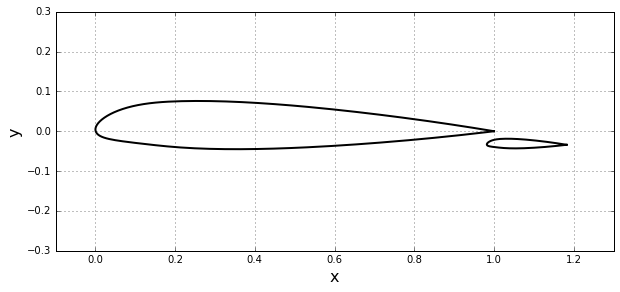

In [7]:
# plot geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(main_x_ends,main_y_ends, color='k', linestyle='-', linewidth=2)
plt.plot(flap_x_ends,flap_y_ends, color='k', linestyle='-', linewidth=2)
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.3)
plt.ylim(-0.3, 0.3);

In [8]:
def total_lift(aoa, aof):
    """Computes the total lift.
    
    Arguments
    ---------
    aoa -- angle of attack.
    aof -- angle of flap.
    
    Returns
    ---------
    L -- lift.
    """
    
    # define freestream conditions 
    u_inf = 1.0
    freestream = Freestream(u_inf, aoa)
    
    # rotate the flap
    flap_x_rot, flap_y_rot = rotate(aof,flap_x_ends,flap_y_ends)

    # create panels
    panels_main = np.empty(N-1, dtype = object)
    panels_flap = np.empty(N-1, dtype = object)
    for i in range(N-1):
        panels_main[i] = Panel(main_x_ends[i], main_y_ends[i], main_x_ends[i+1], main_y_ends[i+1])
        panels_flap[i] = Panel(flap_x_rot[i], flap_y_rot[i], flap_x_rot[i+1], flap_y_rot[i+1])
        
    # combine two parts of panels
    panels = np.empty(2*N-2, dtype = object)
    for i in range(N-1):
        panels[i]=panels_main[i]
        panels[N+i-1]=panels_flap[i]
    
    A_source = source_contribution_normal(panels)
    B_vortex = vortex_contribution_normal(panels)
    
    A = build_singularity_matrix(A_source, B_vortex)
    b = build_freestream_rhs(panels, freestream)
    
    # solve for singularity strengths
    strengths = np.linalg.solve(A, b)
    
    # store source strength on each panel
    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]
        
    # store circulation density
    gamma_main = strengths[-2]
    gamma_flap = strengths[-1]
    
    # computes the tangential velocity and cp at each panel
    compute_tangential_velocity(panels, freestream, gamma_main, gamma_flap, A_source, B_vortex)
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2
        
    # calculates lift
    lift = panel_lift(panels)
    
    return lift

In [9]:
def bisection_for_aoa(a,b,aof,tol):
    """Uses bisection method for solving angles of attack to obtain
    zero lift at fixed angle of flap.
    
    Parameters
    ---------
    a -- interval start.
    b -- interval stop.
    aof -- angle of flap.
    tol -- tolerence.
    
    Returns
    ---------
    aoa_c -- angle of attak when lift is zero.
    """
    
    L_a = total_lift(a, aof)
    L_b = total_lift(b, aof)
        
    if np.sign(L_a) != np.sign(L_b):
        aoa_c = (a+b)/2.
        L_c = total_lift(aoa_c, aof)
    
   
        if np.abs(L_c) < tol:
            print ('The required angle of attack and lift are')
            print (aoa_c, L_c)
        
        else:
            print ('please wait')
            
            if np.sign(L_c) == np.sign(L_a):
                bisection_for_aoa(aoa_c, b, aof, tol)
            else:
                bisection_for_aoa(a, aoa_c, aof, tol)
    

Question 1

In [10]:
bisection_for_aoa(-14,14,20,0.001)

please wait
please wait
please wait
please wait
please wait
please wait
please wait
please wait
please wait
The required angle of attack and lift are
-10.96484375 -0.0003153349731


In [11]:
def bisection_for_aof(a, b, aoa, tol):
    """Uses bisection method for solving angles of flap to obtain
    zero lift at fixed angle of attack.
    
    Parameters
    ---------
    a -- interval start.
    b -- interval stop.
    aoa -- angle of attack.
    tol -- tolerence.
    
    Returns
    ---------
    aof_c -- angle of attak when lift is zero.
    """
    
    L_a = total_lift(aoa, a)
    L_b = total_lift(aoa, b)
    
    if np.sign(L_a) != np.sign(L_b):
        
        aof_c = (a+b)/2.
        L_c = total_lift(aoa, aof_c)
   
        if np.abs(L_c) < tol:
            print ('The required angle of flap and lift are')
            print (aof_c, L_c)
            
        else:
            print ('please wait')
            
            if np.sign(L_c) == np.sign(L_a):
                bisection_for_aof(aof_c, b, aoa, tol)
            else:
                bisection_for_aof(a, aof_c, aoa, tol)


Question 2

In [12]:
bisection_for_aof(-10,10,0,0.001)

please wait
please wait
please wait
please wait
please wait
please wait
please wait
please wait
please wait
The required angle of attack and lift are
-4.51171875 -0.000121508167278


In [13]:
# compute lift for fixed aoa=4, varying aof=0,5,10,15
lift_aof_0 = total_lift(4, 0)
lift_aof_5 = total_lift(4, 5)
lift_aof_10 = total_lift(4, 10)
lift_aof_15 = total_lift(4, 15)

Question 3

In [14]:
print('The speed slowing ratio at 5 deg flap setting is')
1-np.sqrt(lift_aof_0/lift_aof_5)

The speed slowing ratio at 5 deg flap setting is


0.14514725874244438

In [15]:
print('The speed slowing ratio at 10 deg flap setting is')
1-np.sqrt(lift_aof_0/lift_aof_10)

The speed slowing ratio at 10 deg flap setting is


0.24213267017217333

In [16]:
print('The speed slowing ratio at 15 deg flap setting is')
1-np.sqrt(lift_aof_0/lift_aof_15)

The speed slowing ratio at 15 deg flap setting is


0.31281875922639713